In [3]:
# Imports
import torch
from torch import nn  # All neural network modules
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment
import torchvision
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation

In [4]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [7]:
batch_size = 128
num_classes = 10
learning_rate = 0.008
num_epochs = 25

In [8]:
# Making dataset iterable
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        # self.Dropout = nn.Dropout(0.25)
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

        self.masks = torch.nn.ParameterList(
            [torch.nn.Parameter(torch.Tensor(torch.ones([32, 3, 3, 3])), requires_grad=False),
             torch.nn.Parameter(torch.Tensor(torch.ones([32, 32, 3, 3])), requires_grad=False),
             torch.nn.Parameter(torch.Tensor(torch.ones([64, 32, 3, 3])), requires_grad=False),
             torch.nn.Parameter(torch.Tensor(torch.ones([64, 64, 3, 3])), requires_grad=False),
             torch.nn.Parameter(torch.Tensor(torch.ones(128, 1600)), requires_grad=False),
             torch.nn.Parameter(torch.Tensor(torch.ones(num_classes, 128)), requires_grad=False)])
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.bn1(out)
        out = self.max_pool1(out)
        # out = self.Dropout(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.bn2(out)
        out = self.max_pool2(out)
        # out = self.Dropout(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        # out = self.Dropout(out)
        out = self.relu1(out)
        
        out = self.fc2(out)
        return out

In [10]:
model = ConvNeuralNet(num_classes).to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [32]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))          

Epoch [1/25], Loss: 1.9117
Epoch [2/25], Loss: 1.6216
Epoch [3/25], Loss: 1.5096
Epoch [4/25], Loss: 1.3555
Epoch [5/25], Loss: 1.1557
Epoch [6/25], Loss: 0.9923
Epoch [7/25], Loss: 0.8533
Epoch [8/25], Loss: 0.7301
Epoch [9/25], Loss: 0.6162
Epoch [10/25], Loss: 0.5399
Epoch [11/25], Loss: 0.4721
Epoch [12/25], Loss: 0.4012
Epoch [13/25], Loss: 0.3458
Epoch [14/25], Loss: 0.2948
Epoch [15/25], Loss: 0.2557
Epoch [16/25], Loss: 0.2151
Epoch [17/25], Loss: 0.1859
Epoch [18/25], Loss: 0.1540
Epoch [19/25], Loss: 0.1269
Epoch [20/25], Loss: 0.1090
Epoch [21/25], Loss: 0.0899
Epoch [22/25], Loss: 0.0746
Epoch [23/25], Loss: 0.0684
Epoch [24/25], Loss: 0.0612
Epoch [25/25], Loss: 0.0529


In [33]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))
baseline_accuracy = 100 * correct / total

Accuracy of the network on the 50000 train images: 89.62 %


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
import math

In [12]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
def train_model(num_epochs):
    # Set model to training mode in order to unfreeze all layers and allow gradient propagation
    model.train()
    # These two lists will be used to store average loss and accuracy for each epoch
    total_loss, acc = list(), list()
    for epoch in range(num_epochs):
        print("Epoch:", epoch+1)
        # Each batch produces a loss, predictions and target
        batch_loss, batch_preds, batch_target = 0, list(), list()
        #Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save the loss
            batch_loss+= loss.item()
            # Save the predictions and target
            batch_preds.extend(np.argmax(outputs.cpu().detach().numpy(), axis=1))
            batch_target.extend(labels.cpu().detach().numpy())
        # Calculate average loss
        total_loss.append(batch_loss/batch_size)
        total_loss.append(batch_loss/batch_size)
        # Calculate accuracy for this epoch
        acc.append(accuracy_score(batch_target, batch_preds))
        print("Loss:", total_loss[-1], "\tAcc:", acc[-1])
    return model,total_loss, acc    

def test_model():
    # Set model to eval mode in order to freeze all layers so that no parameter gets updated during testing
    model.eval()
    # Each batch produces a loss, predictions and target
    batch_preds, batch_target = list(), list()
    # For each batch, train the model
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # Save the predictions and target
        batch_preds.extend(np.argmax(outputs.cpu().detach().numpy(), axis=1))
        batch_target.extend(labels.cpu().detach().numpy())
    return accuracy_score(batch_target, batch_preds)

In [13]:
# Create the model
model = ConvNeuralNet(num_classes).to(device)
# Define Loss
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# First save the model weights that have been initialized

layer_names=[model.conv_layer1, model.conv_layer2, model.conv_layer3, model.conv_layer4]
# for i in range(4):
#     layer_names.append("model.{}".format(layers[i]))
#     print(layer_names[i])
# for i in range(4):
#     layer_names[i]=exec(layer_names[i])
init_weights = [layer_names[i].weight.data.to(device) for i in range(4)]

def prune_weights(model, sparsity , rounds, epochs):
    for round_ in range(rounds):
        print("\n\n\nROUND", round_+1, "Started\n----------------------")
        # First train the model for some epochs
        model, _, _ = train_model(epochs)
        if round_ == 0:
            print("Test Accuracy before pruning:", test_model())
        else:
            print("Test Accuracy after pruning and retraining:", test_model())
        with torch.no_grad():
            # Now prune the model weights
            for i in range(4):
                num_rows = layer_names[i].weight.data.shape[0]
                num_cols = layer_names[i].weight.data.shape[1]
                # Random pruning
    #             indices = np.random.randint(0, num_rows*num_cols, num_rows*num_cols)
                # Lottery Ticket Style Pruning
                indices = torch.argsort(torch.reshape(torch.abs(layer_names[i].weight.data), (1, num_rows*num_cols,3,3)).squeeze())
                # Since we already have the indices to prune, first reset the parameters
                layer_names[i].weight.copy_(init_weights[i])
                # Now prune
                model.masks[i] = torch.reshape(model.masks[i], (1, num_rows*num_cols,3,3)).squeeze()
                val = ((sparsity*100)**((round_+1)/rounds))/100
                model.masks[i][indices[:math.ceil(val*num_rows*num_cols)]] = 0
                model.masks[i] = torch.reshape(torch.reshape(model.masks[i], (1, num_rows*num_cols,3,3)).squeeze(), (num_rows, num_cols,3,3))
        print("Test Accuracy after pruning but no retraining:", test_model())
    final_acc = test_model()
    return model, final_acc

In [17]:
# Set the number of epochs to be used
epochs = 5
# Set the number of rounds
rounds = 5
# Set the sparsity level for each layer
sparsity_list = [0.1, 0.2, 0.3, 0.4, 0.5]

output = []
for sparsity in sparsity_list:
    model = ConvNeuralNet(num_classes).to(device)
    print("\n\n\nSparsity Level:", sparsity, "\n----------------------")
    output.append = prune_weights(model, sparsity , rounds, epochs)

final_acc = []
for i in range(len(output)):
    final_acc.append(output[i][1])




Sparsity Level: 0.1 
----------------------



ROUND 1 Started
----------------------
Epoch: 1
Loss: 4.548437717370689 	Acc: 0.47022
Epoch: 2
Loss: 3.405701579991728 	Acc: 0.61166
Epoch: 3
Loss: 2.861115257255733 	Acc: 0.6755
Epoch: 4
Loss: 2.535168692469597 	Acc: 0.71188
Epoch: 5
Loss: 2.2974735146854073 	Acc: 0.73832
Test Accuracy before pruning: 0.75734
Test Accuracy after pruning but no retraining: 0.75734



ROUND 2 Started
----------------------
Epoch: 1
Loss: 2.0876939208246768 	Acc: 0.76456
Epoch: 2
Loss: 1.9081882014870644 	Acc: 0.78384
Epoch: 3
Loss: 1.7320710429921746 	Acc: 0.80278
Epoch: 4
Loss: 1.569430329138413 	Acc: 0.8213
Epoch: 5
Loss: 1.4245923581765965 	Acc: 0.83696
Test Accuracy after pruning and retraining: 0.82138
Test Accuracy after pruning but no retraining: 0.82138



ROUND 3 Started
----------------------
Epoch: 1
Loss: 1.3004904775880277 	Acc: 0.84926
Epoch: 2
Loss: 1.1838117305887863 	Acc: 0.86132
Epoch: 3
Loss: 1.0611419142223895 	Acc: 0.87644
Epoch: 4


KeyboardInterrupt: 

In [22]:
print(layer_names[3].weight.data.shape)
# print(output[0].masks[i].shape)



torch.Size([64, 64, 3, 3])


In [23]:
model, _, _ = train_model(epochs)
print("Final Test Accuracy:", test_model(), "\n\n")
total_sparsity = 0
total_params = 0
for i in range(len(layer_names)):
    total_sparsity+= len(torch.where(layer_names[i].weight.data==0)[0])
    total_params+= torch.numel(layer_names[i].weight.data)
print("Total Parameters without pruning:", total_params)
print("Parameters remaining after pruning:", total_params-total_sparsity)
print("Total Sparsity(%):", (total_sparsity/total_params)*100)
print("Model compression ratio:", total_params/(total_params-total_sparsity))

Epoch: 1
Loss: 0.5921440741512924 	Acc: 0.93022
Epoch: 2
Loss: 0.5540176677168347 	Acc: 0.9354
Epoch: 3
Loss: 0.4999071770871524 	Acc: 0.94128
Epoch: 4
Loss: 0.4735678457072936 	Acc: 0.9454
Epoch: 5
Loss: 0.44233623388572596 	Acc: 0.94912
Final Test Accuracy: 0.90476 




AttributeError: 'ConvNeuralNet' object has no attribute 'layers'

### Plot a graph of sparsity vs validation accuracy

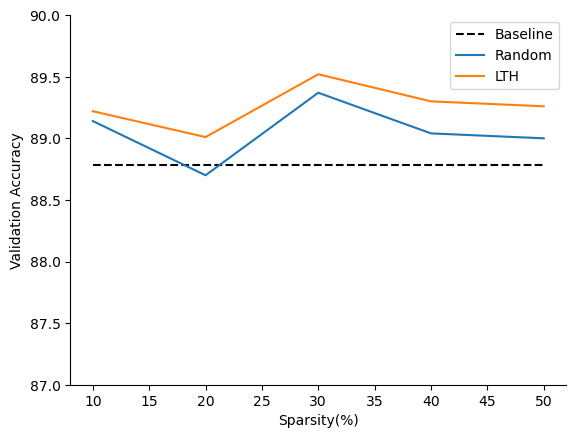

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=[10, 20, 30, 40, 50], y=final_acc, linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[10, 20, 30, 40, 50], y=final_acc, label="Random")
sns.lineplot(x=[10, 20, 30, 40, 50], y=final_acc, label="LTH")
plt.ylim(87, 90)
plt.xlabel("Sparsity(%)")
plt.ylabel("Validation Accuracy")
sns.despine()

### Effect of the number of rounds on model performance

In [25]:
number_of_rounds = [i for i in range(1, 6)]
number_of_epochs = [30, 15, 10, 7, 6]
sparsity = 0.5
output2 = []
for i in range(len(number_of_rounds)):
    output2.append =prune_weights(model, sparsity , number_of_rounds[i], number_of_epochs[i])
    
final_acc2 = []
for i in range(len(output)):
    final_acc2.append(output[i][1])

[1, 2, 3, 4, 5]


In [ ]:
sns.lineplot(x=number_of_rounds, y=final_acc2, label="Round Analysis", color="black")
plt.ylim(87, 90)
plt.xlabel("Rounds")
plt.ylabel("Validation Accuracy")
sns.despine()